In [5]:
!pip install lightgbm

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [7]:
data = pd.read_csv('./data.csv',
                  on_bad_lines='skip')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669640 entries, 0 to 669639
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   password  669639 non-null  object
 1   strength  669640 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 10.2+ MB


In [9]:
print(f'DataFrame shape: {data.shape}')

DataFrame shape: (669640, 2)


In [10]:
print(f"Unique passwords: {len(data['password'].unique())}")

Unique passwords: 669640


In [11]:
# Check for missing values
data.isna().sum()

password    1
strength    0
dtype: int64

In [12]:
data.dropna(inplace=True)

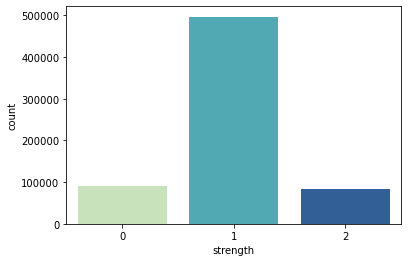

In [13]:
sns.countplot(x=data['strength'], palette='YlGnBu')
plt.show();

In [14]:
medium, weak, strong = data['strength'].value_counts()
print(f'Number of weak passwords: {weak} ({np.round(weak / len(data) * 100,2)}%)')
print(f'Number of medium passwords: {medium} ({np.round(medium / len(data) * 100,2)}%)')
print(f'Number of strong passwords: {strong} ({np.round(strong / len(data) * 100,2)}%)')

Number of weak passwords: 89701 (13.4%)
Number of medium passwords: 496801 (74.19%)
Number of strong passwords: 83137 (12.42%)


In [15]:
#feature engineering

import string
punctuation = list(string.punctuation)

# Count number of characters
data['length'] = data['password'].apply(lambda x: len(x))
# Check if number is in the string
data['has_num'] = data['password'].apply(lambda x: any(char.isdigit() for char in x))
# Count numbers
data['num_cnt'] = data['password'].apply(lambda x: sum(c.isdigit() for c in x))
# Check for lower case
data['has_lower'] = data['password'].apply(lambda x: any(char.islower() for char in x))
# Count lower case
data['lower_cnt'] = data['password'].apply(lambda x: sum(c.islower() for c in x))
# Check for upper case
data['has_upper'] = data['password'].apply(lambda x: any(char.isupper() for char in x))
# Count upper case
data['upper_cnt'] = data['password'].apply(lambda x: sum(c.isupper() for c in x))
# Check for special
data['has_special'] = data['password'].apply(lambda x: any(char in punctuation for char in x))
# Count specials
data['special_cnt'] = data['password'].apply(lambda x: sum(char in punctuation for char in x))

In [16]:
data.head()

,password,strength,length,has_num,num_cnt,has_lower,lower_cnt,has_upper,upper_cnt,has_special,special_cnt
0,kzde5577,1,8,True,4,True,4,False,0,False,0
1,kino3434,1,8,True,4,True,4,False,0,False,0
2,visi7k1yr,1,9,True,2,True,7,False,0,False,0
3,megzy123,1,8,True,3,True,5,False,0,False,0
4,lamborghin1,1,11,True,1,True,10,False,0,False,0


In [17]:
# Get all columns which are numerical
numerical_columns = data.select_dtypes(include=['number']).columns.tolist()
# Convert target to categorical
data['strength'] = data['strength'].astype('category')

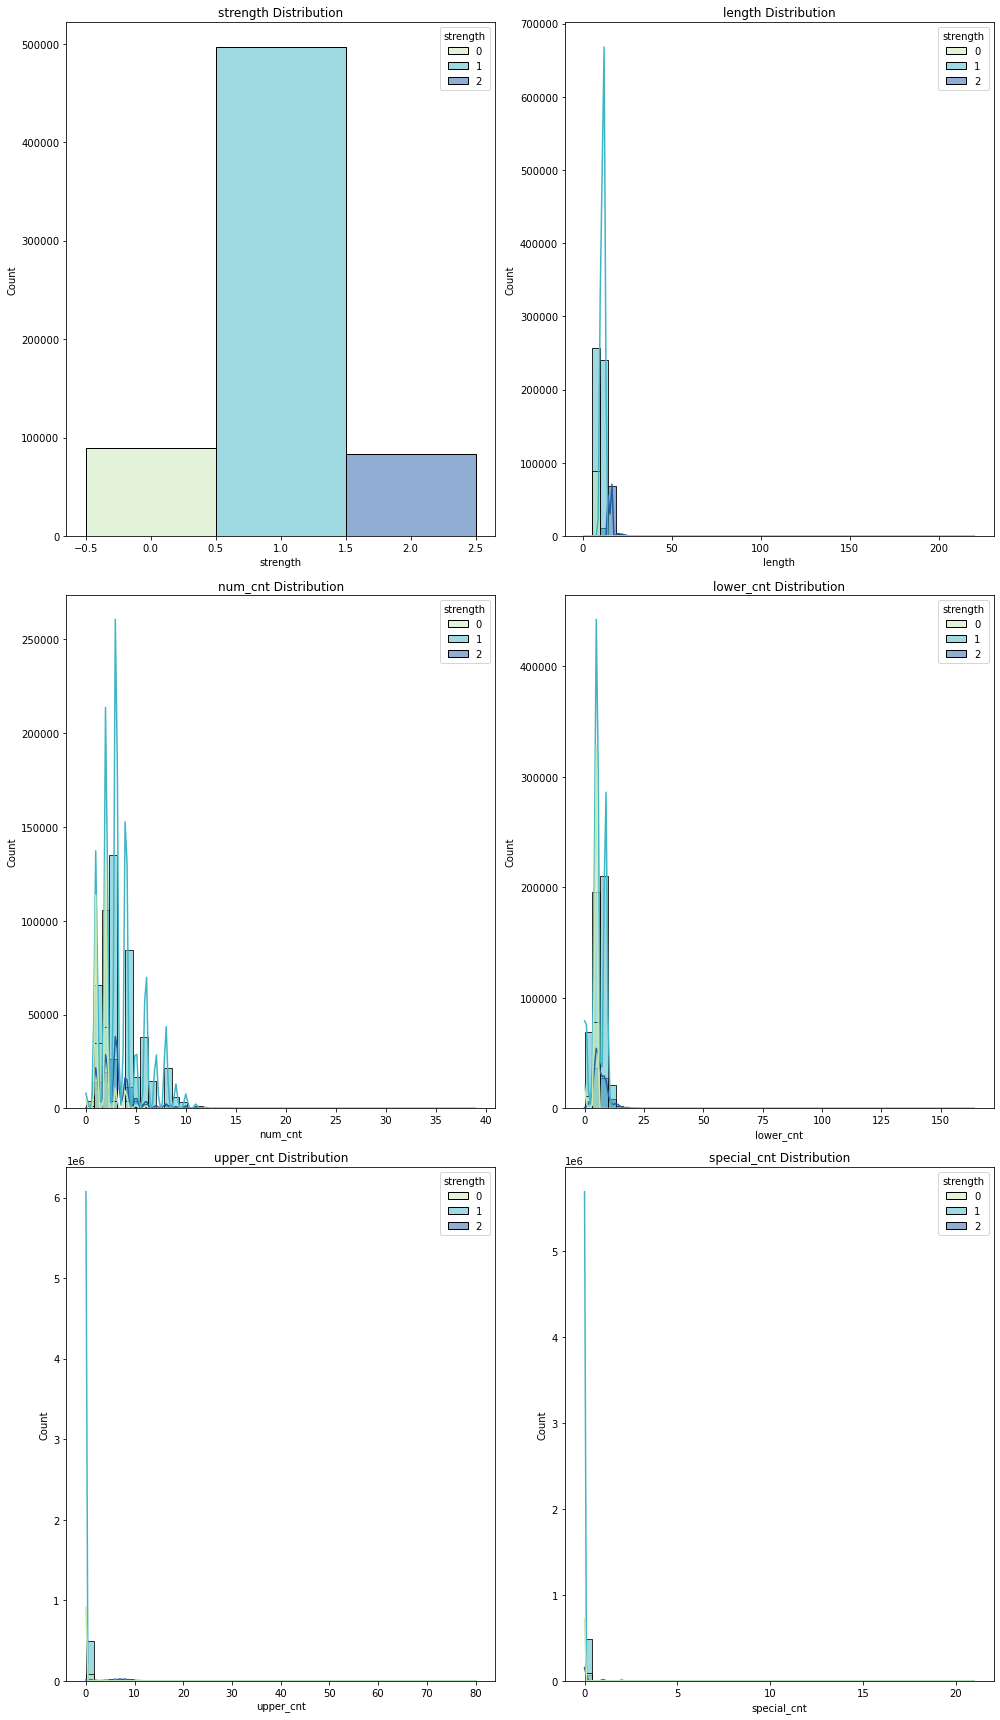

In [18]:
plt.figure(figsize=(14, len(numerical_columns)*4))
for idx, column in enumerate(numerical_columns):
    plt.subplot(len(numerical_columns)//2 + len(numerical_columns)%2, 2, idx+1)
    sns.histplot(x=column, hue="strength", data=data, bins=50, kde=True, palette='YlGnBu')
    plt.title(f"{column} Distribution")
    plt.tight_layout()
    
plt.show()

building model now

In [19]:
X = data.drop(columns=['password', 'strength'])
y = data['strength'].astype(int)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1702)

In [21]:
params = {'objective':'multiclass',
          'num_classes': 3,
          'n_estimators':100,
          'max_depth': 10,
          'learning_rate': 0.05,
          'num_leaves': 70,
          'reg_alpha': 3,
          'reg_lambda': 3,
          'subsample': 0.7,
          'colsample_bytree': 0.7,
          'verbose': -1}

In [22]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [23]:
model = lgb.train(params,
                  train_set=lgb_train,
                  num_boost_round=300,
                  valid_sets=[lgb_train, lgb_eval], # Note: Include your training set if you want to track its performance too.
                  keep_training_booster=True
                  )


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [24]:
y_pred = model.predict(X_test)
y_pred = [np.argmax(p) for p in y_pred]


In [25]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18062
           1       1.00      1.00      1.00     99276
           2       1.00      1.00      1.00     16590

    accuracy                           1.00    133928
   macro avg       1.00      1.00      1.00    133928
weighted avg       1.00      1.00      1.00    133928



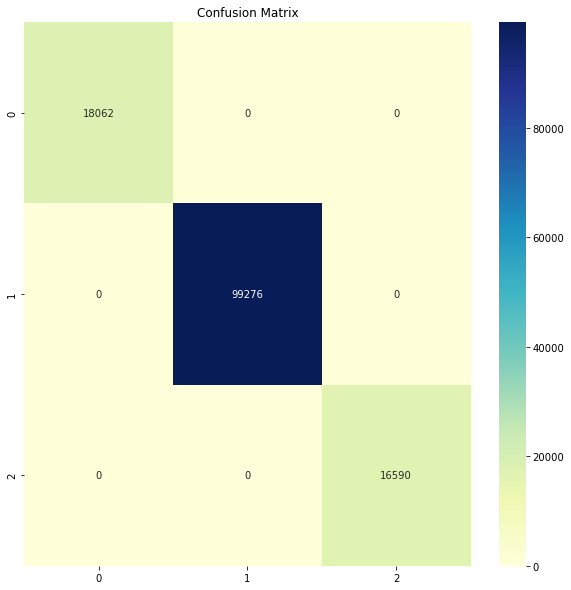

In [26]:
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm)
plt.figure(figsize=(10,10))
sns.heatmap(cm_matrix, annot=True, cmap='YlGnBu', fmt='g')
plt.title('Confusion Matrix')
plt.show();

In [27]:
model.save_model('lgb_model_password_classifier.txt')
model.save_model('lgb_model_password_classifier.lgb')
